1.Load the CIFAR-10 dataset.
(Refer from workshop code)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])                   # data transformation

trainval = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)     # load CIFAR-10 data


trainset, valset = torch.utils.data.random_split(trainval, [0.9, 0.1])          # split into Training and Validation sets


###################                                                             # create data loader for Training and Validation sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)# set num_workers to 0 if windows

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


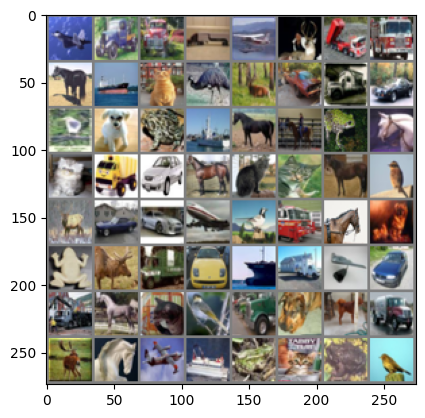

plane truck truck truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

5.setup training and validation for loop

In [6]:
import torch.optim as optim

def train_and_validate(model, trainloader, valloader, criterion, learning_rates, num_epochs=10, patience=3, optimizers=["Adam", "SGD"]):
    best_val_accuracy = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for optimizer_name in optimizers:
        for lr in learning_rates:

            if optimizer_name == "Adam":
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == "SGD":
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            print(f"Training with {optimizer_name} optimizer and learning rate: {lr}")

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_train = 0
                total_train = 0


                for inputs, labels in trainloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()


                    _, predicted = torch.max(outputs, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                train_losses.append(running_loss / len(trainloader))
                train_accuracy = 100 * correct_train / total_train
                train_accuracies.append(train_accuracy)


                model.eval()
                running_val_loss = 0.0
                correct_val = 0
                total_val = 0
                with torch.no_grad():
                    for inputs, labels in valloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        running_val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total_val += labels.size(0)
                        correct_val += (predicted == labels).sum().item()

                val_loss = running_val_loss / len(valloader)
                val_losses.append(val_loss)
                val_accuracy = 100 * correct_val / total_val
                val_accuracies.append(val_accuracy)

                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader)}, "
                      f"Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")

                # Early Stopping
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model_state = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f"No improvement for {patience_counter} epochs. Patience: {patience}")

                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_state)
                    return train_losses, val_losses, train_accuracies, val_accuracies

    model.load_state_dict(best_model_state)
    return train_losses, val_losses, train_accuracies, val_accuracies


6.setup visualising loss function and accuracy for each model

In [7]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # loss function
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()

    plt.show()



confusion matrix

In [8]:
def plot_confusion_matrix(model, testloader, classes):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


Training with Adam optimizer and learning rate: 0.0001
Epoch 1/10, Loss: 1.6633025802333246, Validation Loss: 1.4505, Training Accuracy: 41.07%, Validation Accuracy: 48.08%
Epoch 2/10, Loss: 1.3430393359369852, Validation Loss: 1.3013, Training Accuracy: 52.45%, Validation Accuracy: 54.56%
Epoch 3/10, Loss: 1.2241973100568762, Validation Loss: 1.2475, Training Accuracy: 56.64%, Validation Accuracy: 55.36%
Epoch 4/10, Loss: 1.1379855220121415, Validation Loss: 1.1472, Training Accuracy: 60.16%, Validation Accuracy: 60.26%
Epoch 5/10, Loss: 1.0693279822272332, Validation Loss: 1.1071, Training Accuracy: 62.72%, Validation Accuracy: 61.26%
Epoch 6/10, Loss: 1.0109548805789514, Validation Loss: 1.0775, Training Accuracy: 64.85%, Validation Accuracy: 62.56%
Epoch 7/10, Loss: 0.9669286087155342, Validation Loss: 1.0304, Training Accuracy: 66.53%, Validation Accuracy: 64.14%
Epoch 8/10, Loss: 0.9198970268057152, Validation Loss: 1.0140, Training Accuracy: 68.12%, Validation Accuracy: 64.76%
E

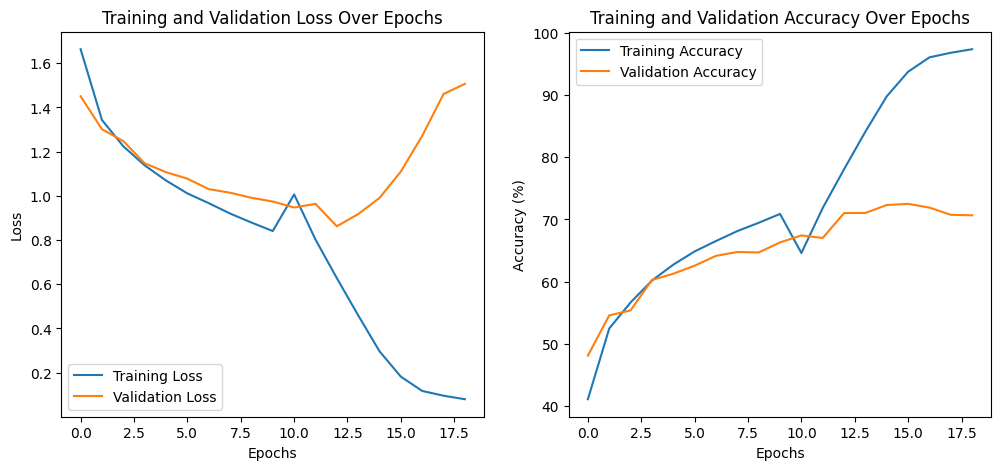

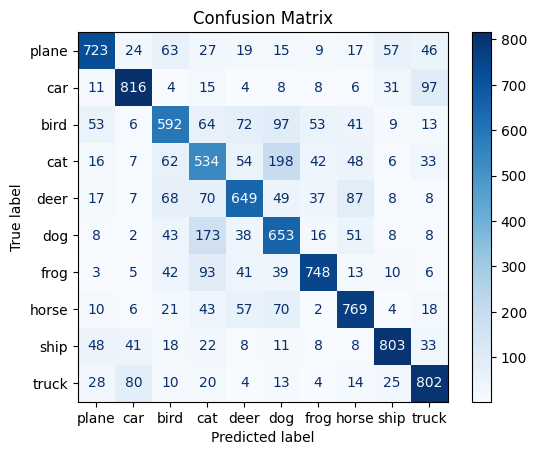

In [37]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



cnn_model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
learning_rates = [0.0001, 0.001, 0.002, 0.005, 0.01]



train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    cnn_model, trainloader, valloader, criterion, learning_rates, num_epochs=10, optimizers=["Adam", "SGD"])

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)




plot_confusion_matrix(cnn_model, testloader, classes)


VGG

In [38]:
import torchvision.models as models

vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(4096, 10)
vgg_model = vgg_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training VGG Model...
Training with Adam optimizer and learning rate: 1e-05
Epoch 1/10, Loss: 0.008727220112503951, Validation Loss: 0.7559, Training Accuracy: 99.75%, Validation Accuracy: 88.96%
Epoch 2/10, Loss: 0.0008542986185936619, Validation Loss: 0.8499, Training Accuracy: 99.98%, Validation Accuracy: 88.88%
No improvement for 1 epochs. Patience: 3
Epoch 3/10, Loss: 0.0007380878013968261, Validation Loss: 0.8930, Training Accuracy: 99.99%, Validation Accuracy: 89.18%
Epoch 4/10, Loss: 0.0008117869403409074, Validation Loss: 0.9313, Training Accuracy: 99.99%, Validation Accuracy: 89.26%
Epoch 5/10, Loss: 0.00032593426942300154, Validation Loss: 0.9898, Training Accuracy: 99.99%, Validation Accuracy: 89.12%
No improvement for 1 epochs. Patience: 3
Epoch 6/10, Loss: 0.0005130671077894676, Validation Loss: 1.0355, Training Accuracy: 99.99%, Validation Accuracy: 89.18%
No improvement for 2 epochs. Patience: 3
Epoch 7/10, Loss: 0.0001861471254254462, Validation Loss: 1.0953, Training 

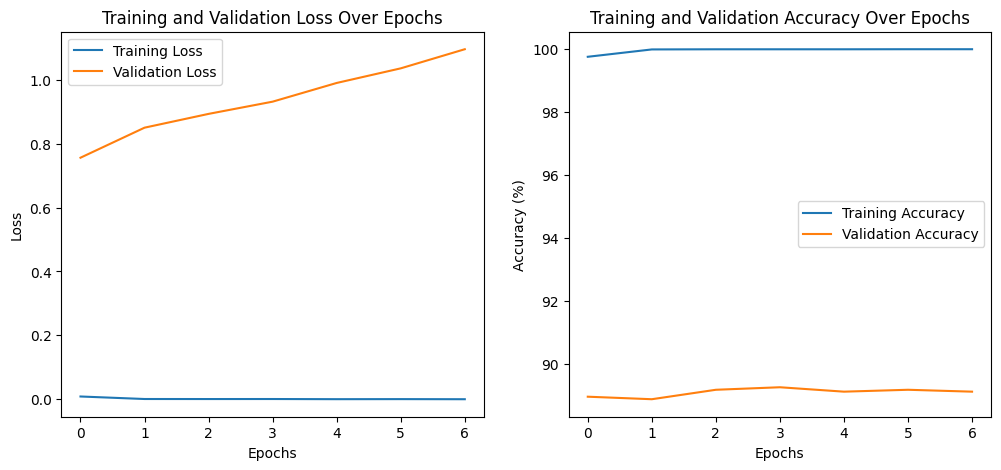

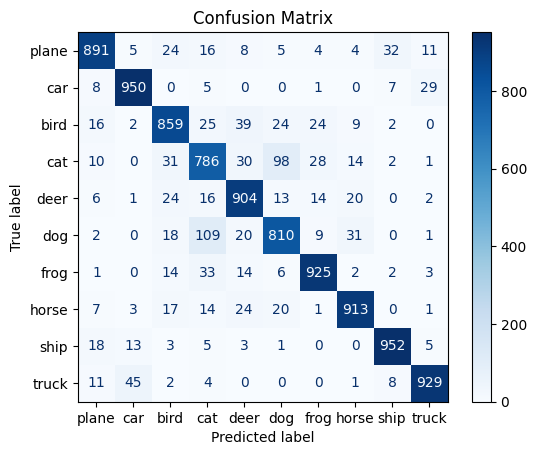

In [44]:
# train and validate VGG
print("Training VGG Model...")
criterion = nn.CrossEntropyLoss()
learning_rates = [0.00001, 0.0001, 0.0002, 0.0005, 0.001]
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    vgg_model, trainloader, valloader, criterion, learning_rates, num_epochs=10, optimizers=["Adam", "SGD"])

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)



plot_confusion_matrix(vgg_model, testloader, classes)

ResNet

In [40]:
# ResNet18
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
resnet_model = resnet_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training ResNet Model...
Training with Adam optimizer and learning rate: 0.0001
Epoch 1/10, Loss: 0.19940361910002222, Validation Loss: 0.5398, Training Accuracy: 93.41%, Validation Accuracy: 84.42%
Epoch 2/10, Loss: 0.10362924705524082, Validation Loss: 0.6260, Training Accuracy: 96.58%, Validation Accuracy: 84.10%
No improvement for 1 epochs. Patience: 3
Epoch 3/10, Loss: 0.057131535503272476, Validation Loss: 0.7074, Training Accuracy: 98.12%, Validation Accuracy: 84.02%
No improvement for 2 epochs. Patience: 3
Epoch 4/10, Loss: 0.03485875882283422, Validation Loss: 0.8388, Training Accuracy: 98.87%, Validation Accuracy: 84.20%
No improvement for 3 epochs. Patience: 3
Early stopping triggered.


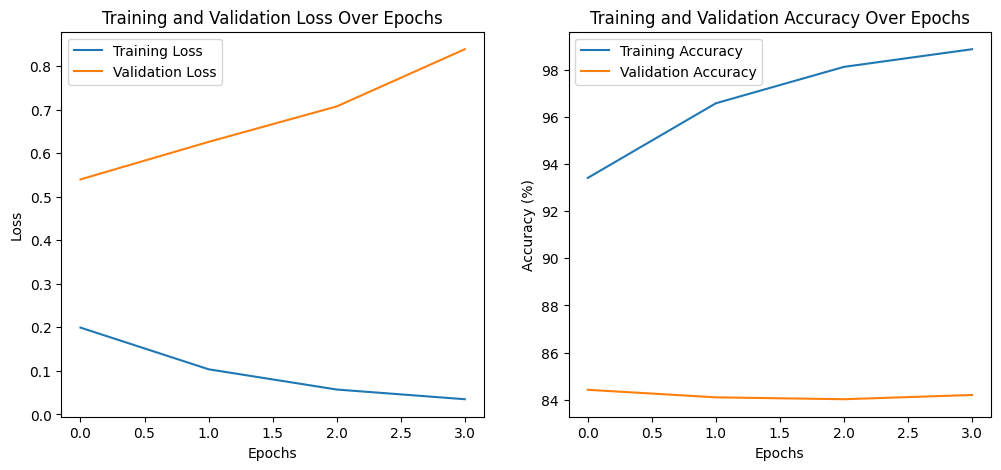

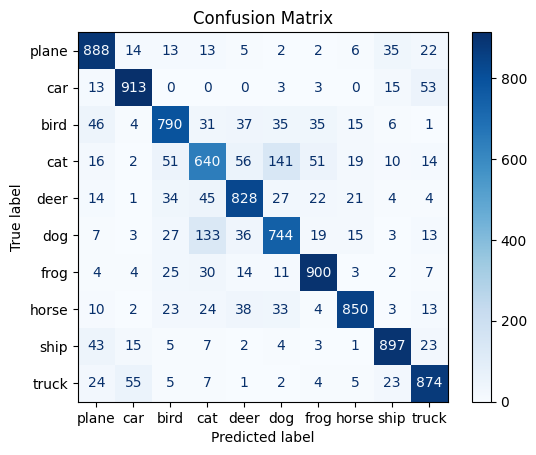

In [43]:
# train and validate ResNet
print("Training ResNet Model...")
learning_rates = [0.00001, 0.0001, 0.0002, 0.0005, 0.001]
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    resnet_model, trainloader, valloader, criterion, learning_rates, num_epochs=10, optimizers=["Adam", "SGD"])

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)



plot_confusion_matrix(resnet_model, testloader, classes)

This is the first outcome that we get.

Now let's try to fix the overfitting problem.

For the data, we can apply data augmentation.

In [45]:
# apply data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [46]:
import torch.optim as optim

def train_and_validate(model, trainloader, valloader, criterion, learning_rates, num_epochs=10, patience=3, optimizers=["Adam", "SGD"]):
    best_val_accuracy = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for optimizer_name in optimizers:
        for lr in learning_rates:

            if optimizer_name == "Adam":
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == "SGD":
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            print(f"Training with {optimizer_name} optimizer and learning rate: {lr}")

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_train = 0
                total_train = 0


                for inputs, labels in trainloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()


                    _, predicted = torch.max(outputs, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                train_losses.append(running_loss / len(trainloader))
                train_accuracy = 100 * correct_train / total_train
                train_accuracies.append(train_accuracy)


                model.eval()
                running_val_loss = 0.0
                correct_val = 0
                total_val = 0
                with torch.no_grad():
                    for inputs, labels in valloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        running_val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total_val += labels.size(0)
                        correct_val += (predicted == labels).sum().item()

                val_loss = running_val_loss / len(valloader)
                val_losses.append(val_loss)
                val_accuracy = 100 * correct_val / total_val
                val_accuracies.append(val_accuracy)

                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader)}, "
                      f"Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
                      f"Validation Accuracy: {val_accuracy:.2f}%")

                # Early Stopping
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model_state = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f"No improvement for {patience_counter} epochs. Patience: {patience}")

                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_state)
                    return train_losses, val_losses, train_accuracies, val_accuracies

    model.load_state_dict(best_model_state)
    return train_losses, val_losses, train_accuracies, val_accuracies


In [47]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # loss function
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()

    plt.show()



In [48]:
def plot_confusion_matrix(model, testloader, classes):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

improved VGG model

In [49]:
# add dropout layers
class ModifiedVGG(nn.Module):
    def __init__(self):
        super(ModifiedVGG, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features


        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


improved ResNet model

In [51]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.resnet.fc.in_features, 10)
        )

    def forward(self, x):
        return self.resnet(x)
resnet_model = ModifiedResNet().to(device)
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


In [52]:


vgg_model = ModifiedVGG().to(device)
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


After modifying the models, now we train and validate.

improved VGG performance

Training modified_VGG Model...
Training with Adam optimizer and learning rate: 0.0001
Epoch 1/10, Loss: 0.0032953863489679366, Validation Loss: 1.9913, Training Accuracy: 99.94%, Validation Accuracy: 73.80%
Epoch 2/10, Loss: 0.00040408861498649043, Validation Loss: 2.0035, Training Accuracy: 100.00%, Validation Accuracy: 74.10%
Epoch 3/10, Loss: 0.00022597299285497354, Validation Loss: 2.0594, Training Accuracy: 100.00%, Validation Accuracy: 74.04%
No improvement for 1 epochs. Patience: 3
Epoch 4/10, Loss: 0.00015490049364592034, Validation Loss: 2.1129, Training Accuracy: 100.00%, Validation Accuracy: 74.06%
No improvement for 2 epochs. Patience: 3
Epoch 5/10, Loss: 0.00010827929755082137, Validation Loss: 2.1711, Training Accuracy: 100.00%, Validation Accuracy: 74.06%
No improvement for 3 epochs. Patience: 3
Early stopping triggered.


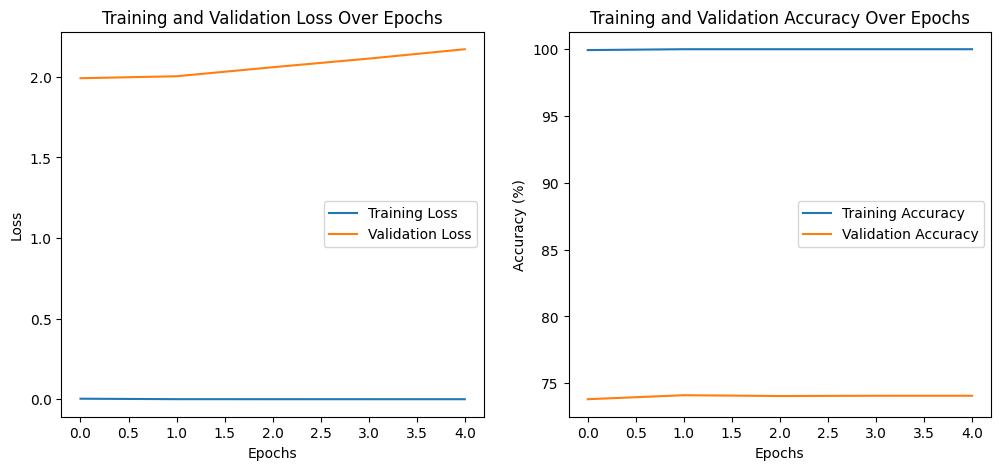

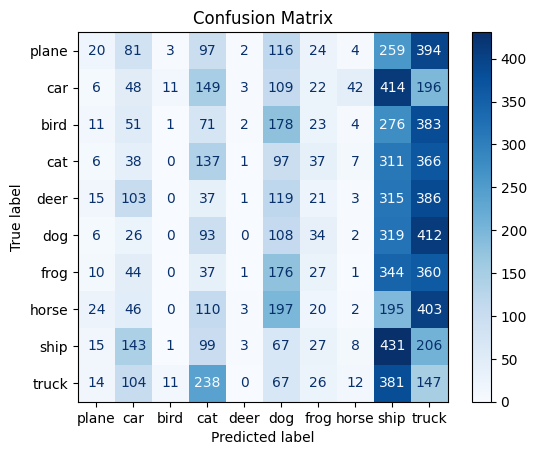

In [54]:
# train and validate VGG
print("Training modified_VGG Model...")
criterion = nn.CrossEntropyLoss()
learning_rates = [0.0001, 0.0005, 0.001, 0.01]

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    cnn_model, trainloader, valloader, criterion, learning_rates, num_epochs=10, optimizers=["Adam", "SGD"])

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)



plot_confusion_matrix(vgg_model, testloader, classes)

improved ResNet performance

Training modified_ResNet Model...
Training with Adam optimizer and learning rate: 0.0001
Epoch 1/10, Loss: 0.00012197338188131694, Validation Loss: 2.3250, Training Accuracy: 100.00%, Validation Accuracy: 74.28%
Epoch 2/10, Loss: 2.9676922270334543e-05, Validation Loss: 2.4236, Training Accuracy: 100.00%, Validation Accuracy: 74.34%
Epoch 3/10, Loss: 1.61030796391434e-05, Validation Loss: 2.5023, Training Accuracy: 100.00%, Validation Accuracy: 74.16%
No improvement for 1 epochs. Patience: 3
Epoch 4/10, Loss: 1.024140064729486e-05, Validation Loss: 2.5704, Training Accuracy: 100.00%, Validation Accuracy: 74.38%
Epoch 5/10, Loss: 7.192977330690424e-06, Validation Loss: 2.6378, Training Accuracy: 100.00%, Validation Accuracy: 74.26%
No improvement for 1 epochs. Patience: 3
Epoch 6/10, Loss: 5.0684101872245826e-06, Validation Loss: 2.6957, Training Accuracy: 100.00%, Validation Accuracy: 74.24%
No improvement for 2 epochs. Patience: 3
Epoch 7/10, Loss: 3.583457921103998e-06, Validation Lo

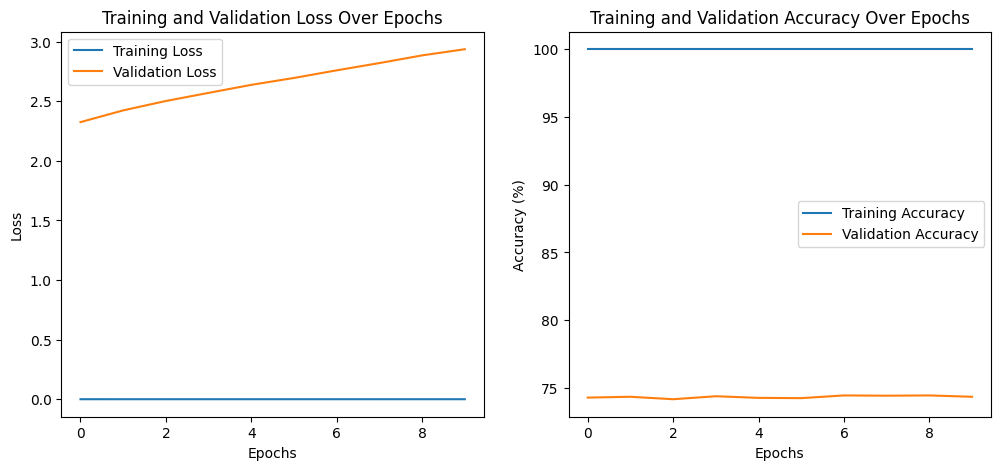

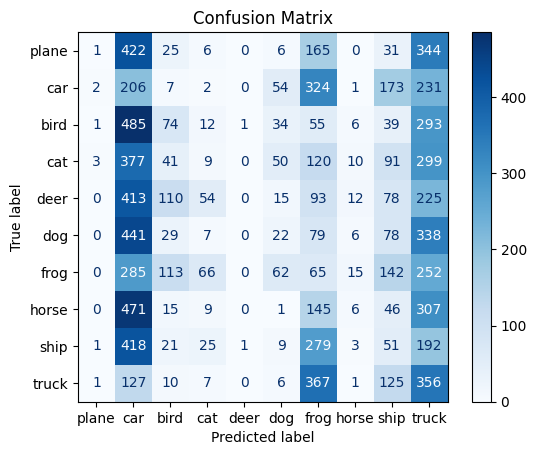

In [55]:
# train and validate ResNet
print("Training modified_ResNet Model...")
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    cnn_model, trainloader, valloader, criterion, learning_rates, num_epochs=10, optimizers=["Adam", "SGD"])

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

plot_confusion_matrix(resnet_model, testloader, classes)